# ECE/CS 434 | MP4: AoA, Beamforming
<br />
<nav>
    <span class="alert alert-block alert-warning">Due on Monday Apr 1th 11:59PM 2024 on Gradescope</span>
</nav><br> 

## Objective
In this MP, you will:
- Implement algorithms (Delay-and-Sum and MUSIC) to find angle of arrivals of voices using recordings from microphone arrays. You will get 100% for Delay-and-Sum implementation. MUSIC is an extra 10%. **We will manually check to make sure you did implement MUSIC for you to get the extra credit.**
- Perform triangulation over multiple AoAs to deduce user locations.
- Optimize voice localization algorithms using tools from probability theory, or signal processing.

---
## Imports & Setup
The following `code` cell, when run, imports the libraries you might need for this MP. Feel free to delete or import other commonly used libraries. Double check with the TA if you are unsure if a library is supported.

In [1]:
import numpy as np
import pandas as pd

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

---
## Problem Description

Providing voice assistants with location information of the user can be helpful in resolving ambiguity in user commands. In this project, you will create a speaker localization algorithm using recordings from multiple voice assistant microphone arrays.

<figure>
<img src="images/scenario.png" alt="AoA Scenario" style="width: 500px;"/>
<figcaption>Figure 1: Application Scenario</figcaption>
</figure>

Consider the following scenario: there are eight voice assistants around the user. We will provide you with the location of these eight devices $L_{0}, L_{1}, \ldots, L_{7}$, their microphone array configuration, and the recordings from each of these devices $D_{0}, D_{1}, \ldots, D_{7}$. Your algorithm should take $D_{0}, D_{1}, \ldots D_{7}$ and $L_{0}, L_{1}, \ldots L_{7}$ as input and output the location of the user $L_{x}$.

The problem has two parts. In part 1, you will implement angle of arrival estimation algorithms on microphone arrays, using both Delay-and-sum algorithm (MUSIC is extra credit). In part 2, you will apply triangluation to find the user location.


---
## Data Specification

Figure 3 shows the microphone array configuration. Each microphone array has 6 microphones indicated by green dots. They form a hexagon with mic #1 facing +x, mic #0 60 degrees counter-clockwise from mic #1, and so on. The diameter of the microphone array is $0.09218\text{ m}$(the distance between mic #0 and mic #3).  The sampling rate is $16000\text{ Hz}$.

Four sets of data can be found in `dataset#/`:
```

├── dataset0
│   ├── 0.csv
│   ├── 1.csv
│   ├── ...
│   ├── 7.csv
│   └── config.csv
├── dataset1
│   ├── ...
├── dataset2
│   ├── ...
└── dataset3
    ├── 0.csv
    ├── 1.csv
    ├── ...
    ├── 7.csv
    └── config.csv
    
```
Each CSV file contains data collected at one of the microphone arrays. Each CSV file has 6 columns, corresponding to recorded samples from individual microphones on the mic array, with column number matching mic number. `config.csv` contains the microphone array coordinates. There are 8 comma-separated rows, corresponding to the (x, y) coodinates of the 8 microphone arrays. This is visualized in Figure 2 below. Note that the coordinates are in metres.

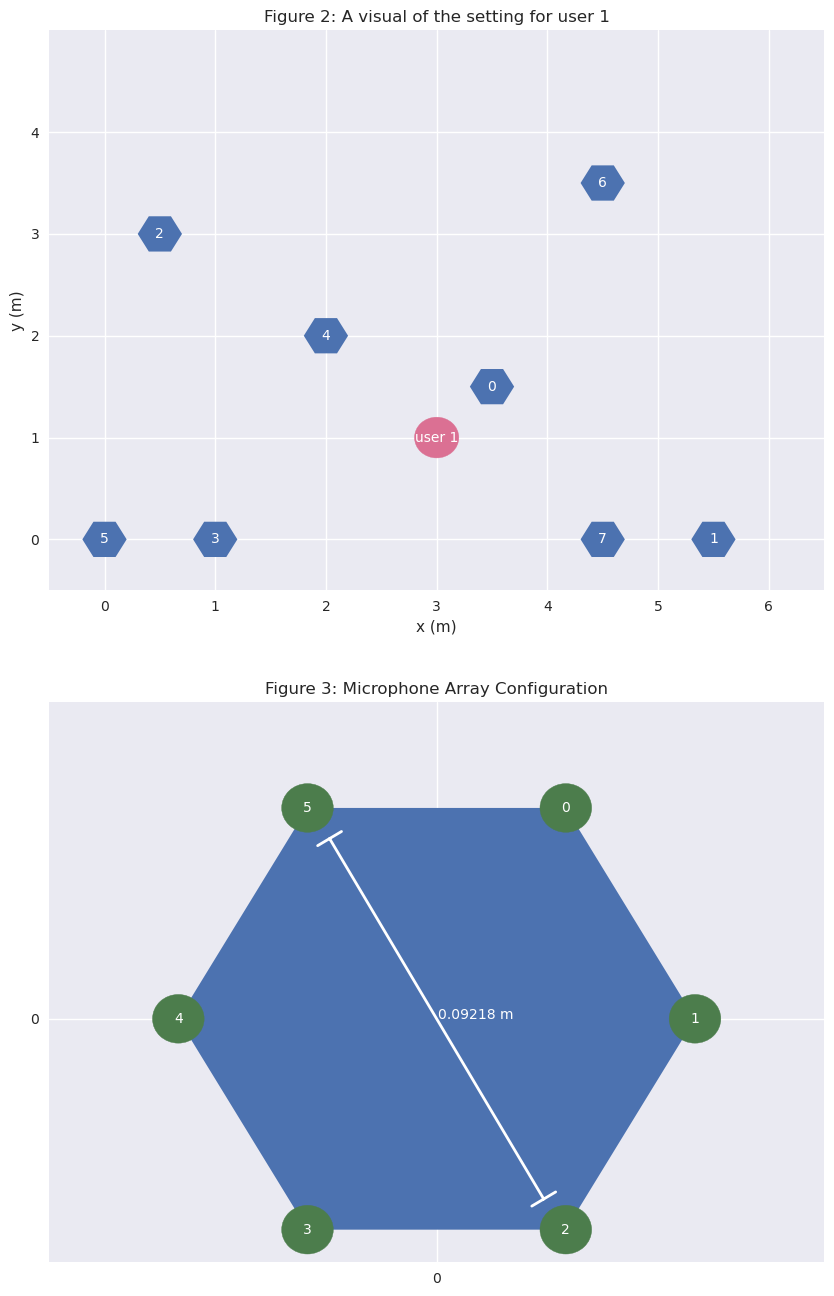

In [2]:
if __name__ == '__main__':
    array_locs = np.genfromtxt ('dataset0/config.csv', delimiter=",")
    user_1_location = np.array((3.0, 1.0))

    from matplotlib.patches import RegularPolygon, Circle
    fig, ax = plt.subplots(2, 1, figsize=(10,16))
    ax[0].set_title("Figure 2: A visual of the setting for user 1")
    ax[0].grid(b=True, which="major", axis="both")
    ax[0].set_xlim((-0.5, 6.5))
    ax[0].set_xticks(np.arange(0, 7))
    ax[0].set_xlabel("x (m)")
    ax[0].set_ylim((-0.5, 5))
    ax[0].set_yticks(np.arange(0, 5))
    ax[0].set_ylabel("y (m)")
    for (loc_num, (loc_x, loc_y)) in enumerate(array_locs, start=0):
        ax[0].add_patch(RegularPolygon(
            xy=(loc_x,loc_y), 
            numVertices=6, 
            radius=0.2, 
            orientation=np.pi/6
        ))
        ax[0].text(
            x=loc_x, 
            y=loc_y, 
            s=loc_num,
            color="white", 
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax[0].add_patch(Circle(xy=user_1_location,radius=0.2, color="#DB7093"))
    ax[0].text(user_1_location[0], user_1_location[1], "user 1", color="white", ha="center", va="center")
    ax[1].set_title("Figure 3: Microphone Array Configuration")
    ax[1].grid(b=True, which="major", axis="both")
    ax[1].set_xlim((-1.5,1.5))
    ax[1].set_xticks([0])
    ax[1].set_ylim((-1.0,1.3))
    ax[1].set_yticks([0])
    ax[1].add_patch(RegularPolygon((0,0), 6, 1, np.pi/6))
    for mic_i in np.arange(6):
        mic_pos = np.e**(-1j * 2 * np.pi / 6 *  mic_i) \
            * np.e**(1j * 2 * np.pi / 6)
        ax[1].add_patch(Circle(
            xy=(mic_pos.real, mic_pos.imag),
            radius=0.1, 
            color="#4c7d4c"
        ))
        ax[1].text(
            x=mic_pos.real, 
            y=mic_pos.imag, 
            s=mic_i,
            color="white", 
            horizontalalignment="center",
            verticalalignment="center",
        )
    ax[1].annotate(
        "",
        xy=(0.42, -0.75),
        xytext=(-0.42, 0.75),
        arrowprops=dict(arrowstyle="|-|", color="white", lw=2)
    )
    ax[1].text(0.15, 0, "0.09218 m", color="white", ha="center")
    plt.show()

---
## Your Implementation
You will implement three functions here. For part 1, implement `delay_and_sum_aoa(mic_data_folder, FS, MIC_OFFSETS)` and `music_aoa(mic_data_folder, FS, MIC_OFFSETS)` to get the incoming signal's [polar angle](https://en.wikipedia.org/wiki/Polar_coordinate_system). You may assume there is only one direction path. MUSIC implementation is an extra 10% credit. Please change the return value of `music_implemented` function to True if you implemented MUSIC as well.

For part 2, implement localization function `aoa_localization(aoas, mic_data_folder)`. Do **NOT** change function signatures. You are, however, free to define and use helper functions. 

You are encouraged to inspect, analyze and optimize your implementation's intermediate results using plots and outputs. Your implementation for `aoa_localization` function should **NOT** output any plots or data. It should only return the user's calculated location.

In [3]:
def music_implemented():
    return False

def music_aoa(mic_data_folder, FS, MIC_OFFSETS):
    """MUSIC AoA algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         the mic datafiles `0.csv` through `7.csv` and `config.csv`.
        FS: microphone sampling frequency - 16kHz.
        MIC_OFFSETS: a list of tuples of each microphone's location relative to the center of its mic array. 
                     This list is calculated based on the diameter(0.09218m) and geometry of the microphone array.
                     For example, MIC_OFFSETS[1] is [0.09218*0.5, 0]. If the location of microphone array #i is
                     [x_i, y_i]. Then [x_i, y_i] + MIC_OFFSETS[j] yields the absolute location of mic#j of array#i.
                     This is provided for your convenience and you may choose to ignore.

    Returns:
        A list of incoming signal's polar angles for all mic arrays.

    """
    aoas = [0, 0, 0, 0, 0, 0, 0, 0] # Please comment out this line after you implement the function
    # Your return value should be the incoming signal's polar angle (between 0 and 2pi)
    return aoas

#reference used: https://pysdr.org/content/doa.html
def delay_and_sum_aoa(mic_data_folder, FS, MIC_OFFSETS):
    """Delay and sum AoA algorithm. Write your code here.

    Args and output same as previous.
    
    """
    aoas = [0, 0, 0, 0, 0, 0, 0, 0] # Please comment out this line after you implement the function

    theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # 1000 different thetas between -180 and +180 degrees
results = []
for theta_i in theta_scan:
   w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Conventional, aka delay-and-sum, beamformer
   r_weighted = w.conj().T @ r # apply our weights. remember r is 3x10000
   results.append(10*np.log10(np.var(r_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize

# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998

plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

    
    # Your return value should be the incoming signal's polar angle (between 0 and 2pi)
    return aoas 

def aoa_localization(aoas, mic_data_folder):
    """AoA localization algorithm. Write your code here.

    Args:
        aoas: output for aoa algorithm.
        mic_data_folder: same as previous.

    Returns:
        The user's location in this format (in metres): (L_x, L_y)

    """

    # Your return value should be the user's location in this format (in metres): (L_x, L_y)
    return (0, 0) 

---
## Running and Testing

Use the cell below to run and test your code, and to get an estimate of your grade.

In [4]:
def calculate_score(calculated, expected):
    calculated = np.array(calculated)
    expected = np.array(expected)
    distance = np.linalg.norm(calculated - expected, ord=2)
    score = max(1 - (distance-1)/3, 0)
    return min(score, 1)

if __name__ == '__main__':
    groundtruth = [(3.0, 1.0), (4.0, 1.0), (3.0, 1.0), (4.0, 1.0)]
    MIC_OFFSETS = [(0.023,0.0399), (0.0461,0), (0.0230,-0.0399), (-0.0230,-0.0399), (-0.0461,0), (-0.0230,0.0399)]
    FS = 16000 # sampling frequency
    
    output = [['Dataset', 'Expected Output', 'Your Score Delay-and-Sum', 'Your Score MUSIC', 'Points Awarded']]
    for i in range(4):
        directory_name = 'dataset{}'.format(i)
        if music_implemented():
            student_aoas_music = music_aoa(directory_name, FS, MIC_OFFSETS)
            student_loc_music = aoa_localization(student_aoas_music, directory_name)
            score_music = calculate_score(student_loc_music, groundtruth[i])
        else:
            score_music = 0
        student_aoas_delay_sum = delay_and_sum_aoa(directory_name, FS, MIC_OFFSETS)
        student_loc_delay_sum = aoa_localization(student_aoas_delay_sum, directory_name)
        score_delay_sum = calculate_score(student_loc_delay_sum, groundtruth[i])
        output.append([
            str(i),
            str(groundtruth[i]), 
            str(score_delay_sum), 
             str(score_music), 
            "{:2.2f}%".format(score_music * 10 + score_delay_sum * 100)
        ])

    output.append([
        '<i>👻 Hidden test 1 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    output.append([
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        "<i>...</i>"])
    output.append([
        '<i>👻 Hidden test 6 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    display_table(output)

---
## Rubric
You will be graded on the four datasets provided to you (5 points each) and six additional datasets under different settings(10 points each). Make sure you are not over-fitting to the provided data. We will use the same code from the **Running and Testing** section above to grade all 10 traces of data. 
You will be graded on the distance between your calculated user location and ground truth. An error of upto $1 \text{ m}$ is tolerated (and still awarded 100% of the grade). An error of $4 \text{ m}$ or above will be awarded a 0 grade. Grades for errors between $1 \text{ m}$ and $4 \text{ m}$ will be scaled proportionally.

---
## Submission Guidlines
This Jupyter notebook (`MP4.ipynb`) is the only file you need to submit on Gradescope. As mentioned earlier, you will only be graded using your implementation of the `aoa_localization` function, which should only return the calculated **NOT** output any plots or data.
**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**